In [51]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.decomposition import PCA
from sklearn import preprocessing
warnings.filterwarnings('ignore')

In [53]:
df = pd.read_csv('diabetic_data.csv')

In [54]:
df["readmitted"] = df["readmitted"].apply(lambda x: 1 if x == "<30" else 0)
readmitted_counts = df["readmitted"].value_counts()
readmitted_percentages = (readmitted_counts / readmitted_counts.sum()) * 100
readmitted_percentages

readmitted
0    88.840084
1    11.159916
Name: count, dtype: float64

### Handing Class Imbalance
- SMOTE + Modeling
- Random Forests with Class Weights
- XGBoost with scale_pos_weight
- Logistic Regression with Class Weights


In [58]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [60]:
X = df.drop(columns=["readmitted"])  # Features
y = df["readmitted"]  # Target variable

X = pd.get_dummies(X, drop_first=True)  # One-Hot Encoding

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [61]:
# Apply SMOTE to training data only (never to test data!)
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the new class distribution after SMOTE
from collections import Counter
print("Class distribution before SMOTE:", Counter(y_train))
print("Class distribution after SMOTE:", Counter(y_train_smote))

Class distribution before SMOTE: Counter({0: 72326, 1: 9086})
Class distribution after SMOTE: Counter({0: 72326, 1: 72326})


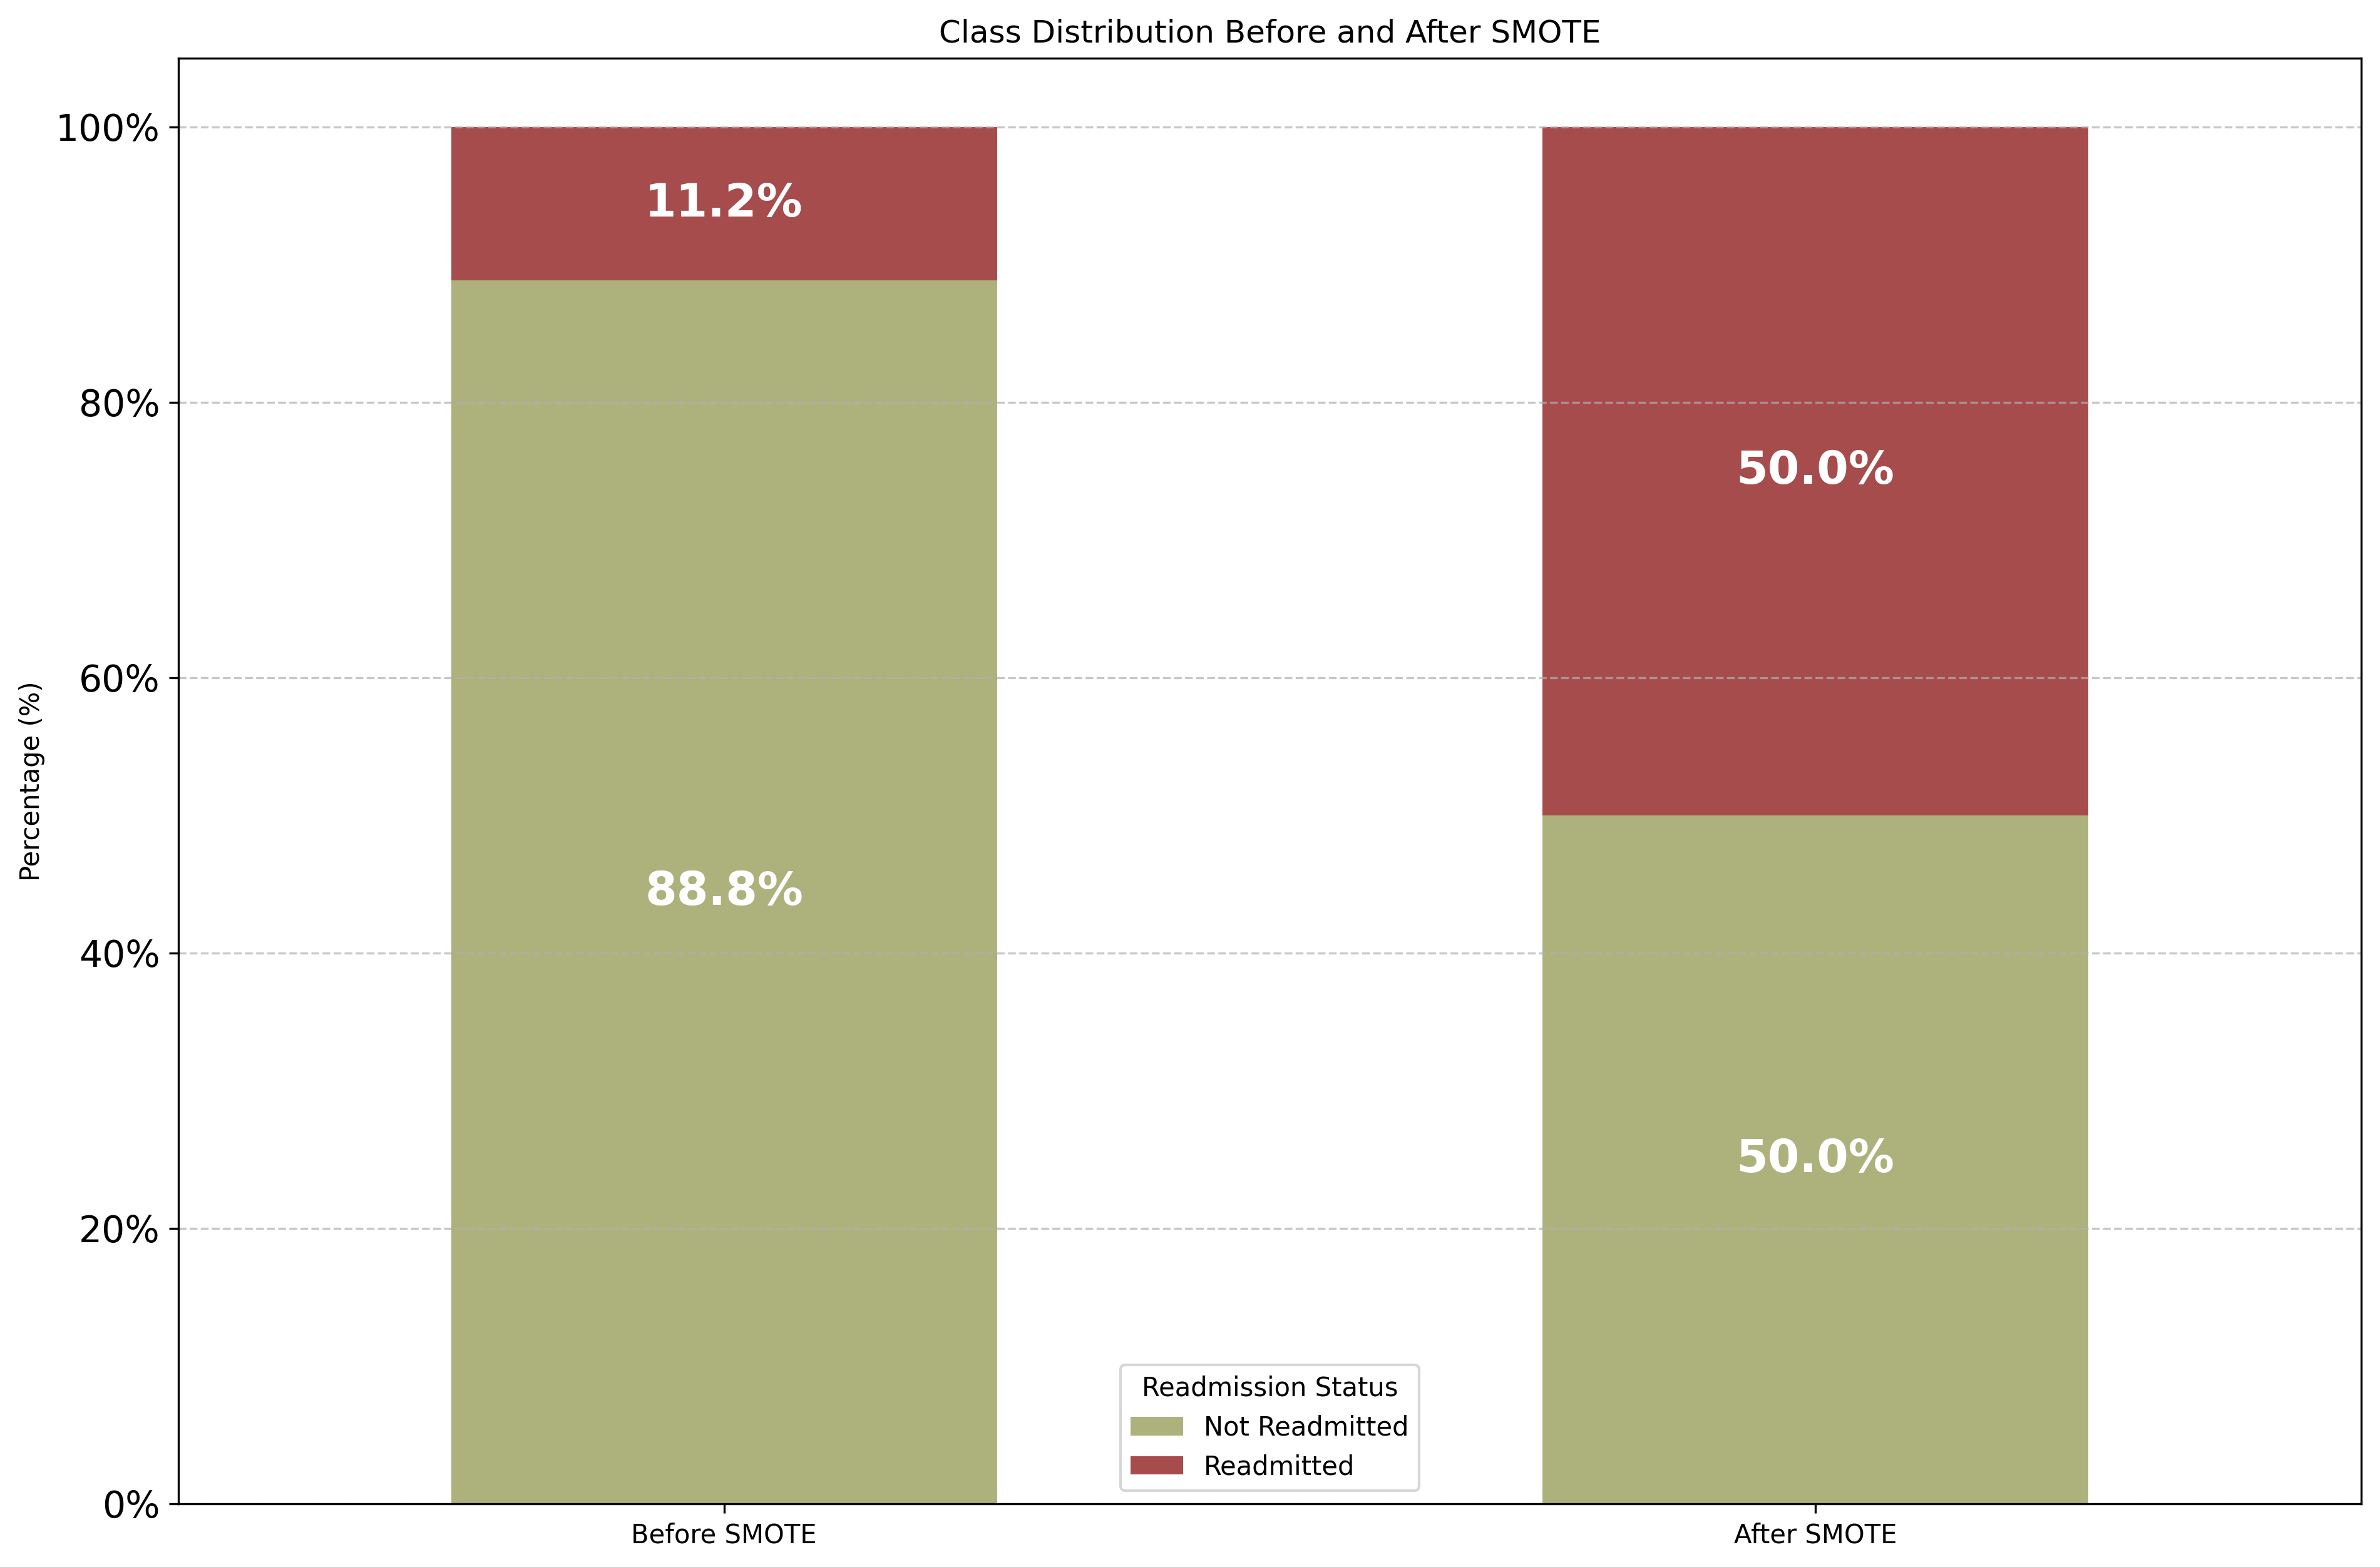

In [94]:
from collections import Counter

# Compute class distribution before SMOTE
readmitted_counts_before = Counter(y_train)
readmitted_counts_after = Counter(y_train_smote)

# Convert to percentage
total_before = sum(readmitted_counts_before.values())
total_after = sum(readmitted_counts_after.values())

readmitted_percentages_before = {
    "Not Readmitted": (readmitted_counts_before[0] / total_before) * 100,
    "Readmitted": (readmitted_counts_before[1] / total_before) * 100,
}

readmitted_percentages_after = {
    "Not Readmitted": (readmitted_counts_after[0] / total_after) * 100,
    "Readmitted": (readmitted_counts_after[1] / total_after) * 100,
}

# Create DataFrame for visualization
df_smote_comparison = pd.DataFrame(
    [readmitted_percentages_before, readmitted_percentages_after],
    index=["Before SMOTE", "After SMOTE"],
)

custom_colors = ["#8A9045", "#800000"]

# Create figure and axis explicitly
fig, ax = plt.subplots(figsize=(15, 10), dpi=300)  # Now properly respects dpi and figsize

# Plot bar chart on the specified axis
df_smote_comparison.plot(kind="bar", stacked=True, color=custom_colors, alpha=0.7, ax=ax)

# Add percentage labels dynamically based on figure size
for i, (idx, row) in enumerate(df_smote_comparison.iterrows()):
    cumulative_height = 0
    for j, (category, value) in enumerate(row.items()):
        percentage = np.round(value, 1)  # Round to one decimal place
        cumulative_height += value / 2  # Position label at the center of the section
        ax.text(i, cumulative_height, f"{percentage}%", ha="center", va="center", 
                fontsize=max(6, fig.get_figheight() * 1.75),  # Scale font size dynamically
                color="white", fontweight="bold")
        cumulative_height += value / 2  # Move to next section

ax.set_yticks(np.arange(0, 101, 20))  # Adjust tick marks every 10%
ax.set_yticklabels([f"{int(tick)}%" for tick in ax.get_yticks()], fontsize = 14)
ax.set_ylabel("Percentage (%)")
ax.set_title("Class Distribution Before and After SMOTE")
ax.set_xticklabels(df_smote_comparison.index, rotation=0)
ax.legend(title="Readmission Status")
ax.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [ ]:
# Import required libraries
from scipy.stats import chi2_contingency

# Set visualization settings
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.family"] = "Helvetica"  # Use Helvetica font
plt.rcParams["savefig.dpi"] = 150          # Set DPI for higher-quality plots

# Define the EDA functions

## Function to summarize categorical columns with top 10 values
def summarize_categorical(df, cat_columns):
    for col in cat_columns:
        print(f"\n--- Summary for Categorical Column: {col} ---")
        # Get the top 10 categories by frequency
        top_categories = df[col].value_counts(normalize=True).head(10)
        print(top_categories)
        print(f"Unique Values: {df[col].nunique()}")
        print(f"Missing Values: {df[col].isnull().sum()}")

        # Plot the top 10 categories
        sns.countplot(
            data=df[df[col].isin(top_categories.index)],
            x=col,
            order=top_categories.index,
            palette="viridis"
        )
        plt.title(f"Top 10 Categories for {col}")
        plt.xticks(rotation=45)
        plt.show()

## Function to summarize continuous columns
def summarize_continuous(df, cont_columns):
    for col in cont_columns:
        print(f"\n--- Summary for Continuous Column: {col} ---")
        print(df[col].describe())
        print(f"Missing Values: {df[col].isnull().sum()}")
        sns.histplot(df[col], kde=True, color="blue", bins=30)
        plt.title(f"Distribution of {col}")
        plt.show()
        sns.boxplot(x=df[col], palette="viridis")
        plt.title(f"Boxplot of {col}")
        plt.show()

## Function to examine relationships between categorical and continuous
def analyze_cat_cont_relationship(df, cat_columns, cont_columns):
    for cat in cat_columns:
        for cont in cont_columns:
            print(f"\n--- Analyzing {cont} by {cat} ---")
            top_categories = df[cat].value_counts().head(10).index
            sns.boxplot(
                data=df[df[cat].isin(top_categories)],
                x=cat,
                y=cont,
                palette="viridis"
            )
            plt.title(f"{cont} by {cat} (Top 10 Categories)")
            plt.xticks(rotation=45)
            plt.show()

## Function to examine relationships between two categorical variables
def analyze_cat_cat_relationship(df, cat_columns):
    for i, col1 in enumerate(cat_columns):
        for col2 in cat_columns[i+1:]:
            print(f"\n--- Analyzing {col1} and {col2} ---")
            top_categories_col1 = df[col1].value_counts().head(10).index
            top_categories_col2 = df[col2].value_counts().head(10).index
            contingency_table = pd.crosstab(
                df[df[col1].isin(top_categories_col1)][col1],
                df[df[col2].isin(top_categories_col2)][col2]
            )
            chi2, p, _, _ = chi2_contingency(contingency_table)
            print(f"Chi-Square Test p-value: {p}")
            sns.heatmap(contingency_table, annot=True, fmt='d', cmap="viridis")
            plt.title(f"Heatmap of {col1} vs {col2} (Top 10 Categories Each)")
            plt.show()

## Function to examine relationships between two continuous variables
def analyze_cont_cont_relationship(df, cont_columns):
    sns.pairplot(df[cont_columns], diag_kind="kde", palette="viridis")
    plt.title("Pairwise Relationships")
    plt.show()

## General function for initial EDA
def initial_eda(df):
    print("\n--- Dataset Overview ---")
    print(df.info())
    print("\n--- Missing Value Summary ---")
    print(df.isnull().sum())

    # Automatically split columns
    cat_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
    cont_columns = df.select_dtypes(include=['number']).columns.tolist()

    print(f"\nCategorical Columns: {cat_columns}")
    print(f"Continuous Columns: {cont_columns}")

    if cat_columns:
        print("\n--- Categorical Variables Analysis ---")
        summarize_categorical(df, cat_columns)

    if cont_columns:
        print("\n--- Continuous Variables Analysis ---")
        summarize_continuous(df, cont_columns)

    if cat_columns and cont_columns:
        print("\n--- Categorical vs Continuous Variables ---")
        analyze_cat_cont_relationship(df, cat_columns, cont_columns)

### Exploratory Data Analysis:
- Race: 2% missing race data
- Age: Older patients, 50+ is the majority class
- Weight: Missing weight data
- Payer Code: 40% missing
- Medical Speciality: 50% missing

In [ ]:
initial_eda(df)